[ Pytorch Penguin Model ]

- 주제 : 펭귄 품종 분류 모델
- 데이터 : penguins.csv
- 지도학습 - 분류 (다중 분류)

In [1]:
# [1-1] 모듈 로딩
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler  # 스케일링 모듈
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder # 인코딩 모듈 

In [2]:
# [1-2] 데이터 로딩 
peng_df = pd.read_csv('penguins.csv')

peng_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [3]:
# [1-3] 실제 데이터와 타입 체크 
peng_df.head(2)

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   

   body_mass_g     sex  
0       3750.0    MALE  
1       3800.0  FEMALE

In [4]:
# [1-4] 결측치 처리 
peng_df = peng_df.dropna()

peng_df.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In [5]:
# [1-5] 피쳐 전처리 
print(peng_df['species'].unique())
print(peng_df['island'].unique())
print(peng_df['sex'].unique())

['Adelie' 'Chinstrap' 'Gentoo']
['Torgersen' 'Biscoe' 'Dream']
['MALE' 'FEMALE']


In [6]:
# [1-6] 범주형 데이터 수치화
pd.set_option('future.no_silent_downcasting', True)

for col in ['species','island','sex']:
    result = peng_df[col].unique()
    peng_df[col] = peng_df[col].replace({result[idx]:idx for idx in range(len(result))})
    peng_df[col] = peng_df[col].astype(int)

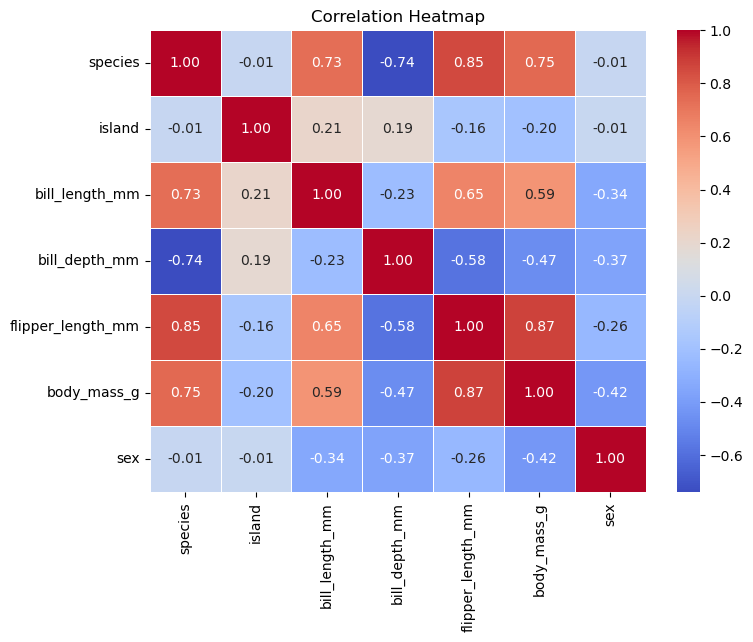

In [7]:
# [1-7] 탐색적 분석 - 상관계수 
corr_matrix = peng_df.corr(numeric_only=True)

# 시각화 1
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


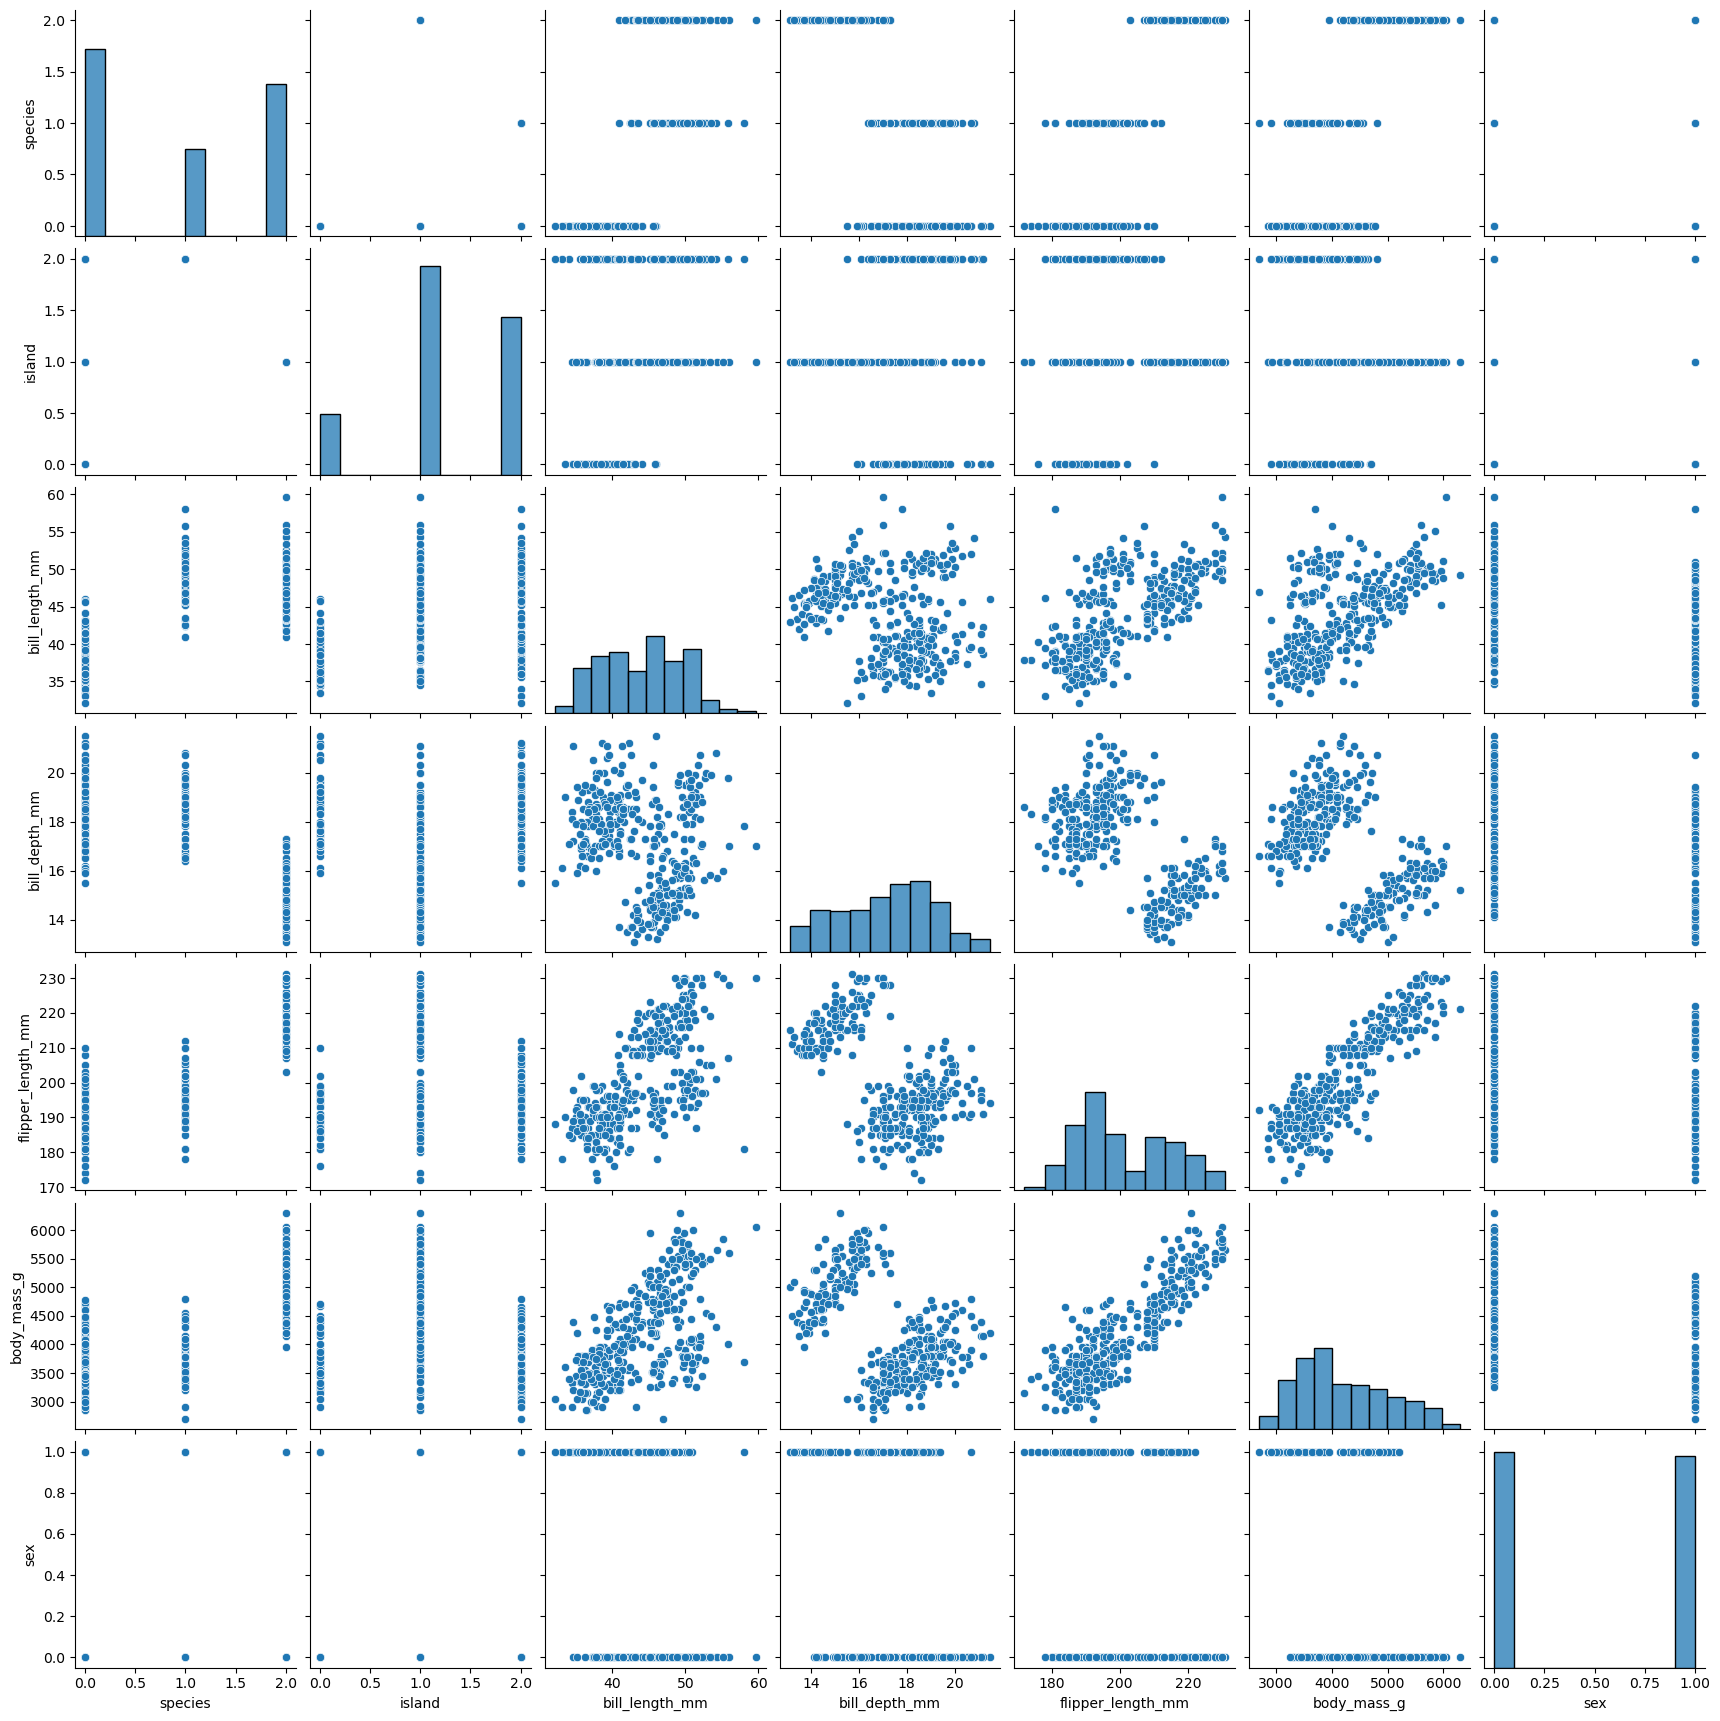

In [8]:
# 시각화 2
sns.pairplot(peng_df)

In [9]:
# 수치형 피쳐 스케일링
f_df = peng_df[peng_df.columns[2:-1]]

Scaler = MinMaxScaler()
scaler_np = Scaler.fit_transform(f_df)
scaler_df = pd.DataFrame(scaler_np)

In [10]:
# 피쳐들 간의 관계성 확인 
corr = scaler_df.corr()
corr

0         1         2         3
0  1.000000 -0.228626  0.653096  0.589451
1 -0.228626  1.000000 -0.577792 -0.472016
2  0.653096 -0.577792  1.000000  0.872979
3  0.589451 -0.472016  0.872979  1.000000

In [11]:
# 피쳐 선택 : bill_length, bill_depth, body_mass 
# 타겟 : species 

In [12]:
# [ 신경망 모델 구현 순서 ] 
# - 피쳐와 타겟 분리
# - 피쳐와 타겟 가공
# - 학습용 / 테스트용 분리
# - 학습용 기준으로 표준화 및 정규화 진행
# - 데이터셋 클래스 설계 및 구현
# - 모델 클래스 설계 및 구현
# - 학습 진행 
# - 학습 결과 분석 
# - 튜닝 여부 결정
# - 모델 저장 및 서비스 연동 

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import *
from torchinfo import summary

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [23]:
# 피쳐 / 타겟 분리
featureDF = peng_df[['bill_length_mm', 'bill_depth_mm', 'body_mass_g']]
TargetSR = peng_df[peng_df.columns[0]]

In [27]:
# 데이터 분리
x_train, x_test, y_train, y_test = train_test_split(featureDF, 
                                                    TargetSR,
                                                    stratify=TargetSR,
                                                    random_state=42)

In [28]:
# shape 확인
print(x_train.shape)
print(y_train.shape)

(249, 3)
(249,)


In [ ]:
# 학습용을 기준으로 정규화 진행 

# 연속형 피쳐 스케일링
mmScaler = MinMaxScaler()
mmScaler.fit(x_train)

scaled_x_train = mmScaler.transform(x_train)
scaled_x_test = mmScaler.transform(x_test)

In [ ]:
# 타겟 인코딩
lbEncoder = LabelEncoder()
lbEncoder.fit(y_train)
y_train = lbEncoder.transform(y_train)
y_test = lbEncoder.transform(y_test)

In [ ]:
# 펭귄 데이터에 대한 전용 Dataset 클래스 정의
# 클래스이름 : PenguinDS
# 데이터구성 : 피쳐 3 + 타겟 1 (타겟도 DF로 받음)
# 필수메서드 : __init__(self, 피쳐DF, 타겟DF)
#             __len__(self) => return 샘플 수 
#             __getitem__(self,index) => return index 해당하는 피쳐와 타겟 (단!! tensor)

In [34]:
class PenguinDS(nn.Module):
    
    def __init__(self, featureDF, targetDF):
        super().__init__()
        self.feature = featureDF
        self.target = targetDF
        self.n_feature = featureDF.shape[1]
        self.n_samples = featureDF.shape[0]
        
        
    def __len__(self):
        return self.n_samples
    
    
    def __getitem__(self, index):
        farr = self.feature.iloc[index].values
        tarr = self.target.iloc[index].values
        return torch.FloatTensor(farr), torch.LongTensor(tarr)

In [39]:
# DS 확인
fDF = pd.DataFrame(scaled_x_train)
tDF = pd.Series(y_train).to_frame()

testDS = PenguinDS(fDF, tDF)
testDS[0]

(tensor([1.]), tensor([1]))

In [ ]:
# 펭귄 데이터에 대한 전용 Dataset 클래스 정의
# 클래스이름 : PenguinNpDS
# 데이터구성 : 피쳐 3 NP + 타겟 1 NP
# 필수메서드 : __init__(self, 피쳐NP, 타겟NP)
#             __len__(self) => return 샘플 수 
#             __getitem__(self,index) => return index 해당하는 피쳐와 타겟 (단!! tensor)

In [ ]:
class PenguinDS(nn.Module):
    
    def __init__(self, featureNP, targetNP):
        super().__init__()
        self.feature = featureNP
        self.target = targetNP
        self.n_feature = featureNP.shape[1]
        self.n_samples = featureNP.shape[0]
        
        
    def __len__(self):
        return self.n_samples
    
    
    def __getitem__(self, index):
        return torch.FloatTensor(self.feature[index]), torch.LongTensor(self.target[index])